<a href="https://colab.research.google.com/github/nachovera93/IA-Documents/blob/main/Laboratorio_3_Redes_Convolucionales_Ricardo_Vera.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Nombre:** Ricardo Vera

<br>


###Para mayor comodidad implemente este nuevo notebook donde solo traslade las funciones y partes de codigos que sirven para la actividad, cada respuesta esta indicada ordenadamente mas abajo.


<br>



In [1]:
!pip install -U matplotlib

Requirement already up-to-date: matplotlib in /usr/local/lib/python3.6/dist-packages (3.3.3)


In [2]:
import torch
import torchvision.models as models # torchvision.models contiene varios modelos interesantes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # variable para enviar los datos a CPU o GPU

alexnet = models.alexnet(pretrained=True).to(device).eval()     # descargamos Alexnet
                                                                # el parámetro pretrained=True hará que se descarguen los pesos del modelo entrenado en Imagenet
                                                                # luego enviamos el modelo a la CPU o GPU según la variable device
                                                                # finalmente dejamos el modelo en modo evaluación con eval()

resnet50 = models.resnet50(pretrained=True).to(device).eval()

In [3]:
!pip install torch-lucent

In [4]:
from lucent.optvis import render, param, transform, objectives # importamos los módulos que usaremos para visualizar los features
from lucent.modelzoo.util import get_model_layers # esta función nos permite ver el nombre de las capas de un modelo

In [5]:
import matplotlib.pyplot as plt # librería para desplegar gráficos
def get_images(model, layers, rows, cols, preprocess=True, transforms=None):  # función auxiliar para graficar una grilla de visualizaciones
    fig = plt.figure(figsize=(4*len(layers)*cols, 4*rows))
    outer_grid = fig.add_gridspec(1, len(layers))

    for layer_index, layer in enumerate(layers):
      inner_grid = outer_grid[0, layer_index].subgridspec(rows, cols, wspace=0, hspace=0)
      axs = inner_grid.subplots()
      for i in range(rows):
          for j in range(cols):
              image = render.render_vis(model, f'{layer}:{i*cols+j}', preprocess=preprocess, transforms=transforms)[0][0] # Acá estamos calculando la imagen de la capa y canal correspondiente
              ax = axs[i][j]
              ax.imshow(image)
              if i==(rows-1) and j==cols//2:
                ax.set_xlabel(layer, fontsize=18)
              ax.set(xticks=[], yticks=[])

    plt.show()

<br>

###Con estas funciones manipulamos el dataset de flores:

<br>


In [6]:
from test_model import test_model # función para evaluar el rendimiento de un modelo en un dataset
from torch.utils.data import DataLoader

In [7]:
from os import listdir
from os.path import join

from PIL import Image
import torch
from torchvision.transforms import Compose, ToTensor, Resize, Normalize
class Flowers(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.imagenes = []       # Vincula el indice con un nombre de archivo
        self.imgs_to_class = []  # Vincula el indice con una clase
        self.imagenes, self.imgs_to_class = self.armar_indices(root)
    
    def armar_indices(self, root):
        n_classes = len(listdir(root)) # El número de carpetas es la cantidad de clases
        contador = 0
        lista_imagenes = []
        imgs_to_class = []
        for clase in sorted(listdir(root)):
            directorio = join(root, clase)
            for archivo in sorted(listdir(directorio)):
                lista_imagenes.append(archivo)
                contador+=1
                imgs_to_class.append(int(clase))

        return lista_imagenes, imgs_to_class

    def obtener_imagen(self, archivo):

        im = Image.open(archivo)
        return im

    def __getitem__(self, idx):

        nombre_archivo = self.imagenes[idx]
        clase = self.imgs_to_class[idx]
        ruta_img = join(self.root, str(clase))
        ruta_img = join(ruta_img, nombre_archivo)
        img = self.obtener_imagen(ruta_img)

        if self.transform is not None:
            img = self.transform(img)
        return img, clase
    
    def __len__(self):
        return len(self.imagenes)



<br>



#**Respuesta Actividad 1:**



<br>


####Primero descomprimimos el dataset de flores, elegimos la arquitectura de resnet50 y la modificamos para que sea compatible con el dataset de flores:


<br>


In [8]:
!wget https://www.dropbox.com/s/q53g4cmpnvzhnhi/flowers.tar.gz -q --show-progress
!tar -xzf flowers.tar.gz

flowers.tar.gz.3    100%[===================>] 328.99M   138MB/s    in 2.4s    


In [9]:
import torch
import torchvision.models as models
import torch.nn as nn

### Resnet50
model = models.resnet50()
model.fc = nn.Linear(2048, 102)


<br>

###Descargamos los pesos de resnet50 y los cargamos a nuestro modelo.

<br>


In [10]:
!wget https://www.dropbox.com/s/q308auknnt8szzw/base_resnet50.pth

--2020-11-26 00:25:39--  https://www.dropbox.com/s/q308auknnt8szzw/base_resnet50.pth
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/q308auknnt8szzw/base_resnet50.pth [following]
--2020-11-26 00:25:39--  https://www.dropbox.com/s/raw/q308auknnt8szzw/base_resnet50.pth
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc725d29c1287548c432ec9ea776.dl.dropboxusercontent.com/cd/0/inline/BD7mX_37K7pn21K6NbvDcMDosUkkd4jyNpurnXyGQVEJQmRjw2WI9tjaBOJMfHp1eymwzushGJHA2qzrt9fMqe8ks_ZRPYEfW6T4EN8uQTk0ny3F0eBLShEYcXwG_nSZpVI/file# [following]
--2020-11-26 00:25:39--  https://uc725d29c1287548c432ec9ea776.dl.dropboxusercontent.com/cd/0/inline/BD7mX_37K7pn21K6NbvDcMDosUkkd4jyNpurnXyGQVEJQmRjw2WI9tjaBOJMfHp1eymwzushGJHA2qzrt9fMqe8ks_ZRPYEfW6T

In [11]:
weights_resnet50 = torch.load('base_resnet50.pth')
model.load_state_dict(weights_resnet50)
model.to(device)
_ = model.eval()

In [12]:
transforms = Compose([Resize((224,224)), ToTensor()])

ds_train = Flowers("flowers_dataset/train", transform=transforms)
train_dl = DataLoader(ds_train, batch_size=256)

ds_test = Flowers("flowers_dataset/test", transform=transforms)
test_dl = DataLoader(ds_test, batch_size=256)

In [13]:
test_model(model, train_dl)

Correctas: 5212.0 Total: 5687.0 Accuracy: 91.65%

In [14]:
test_model(model, test_dl)

Correctas: 2194.0 Total: 2666.0 Accuracy: 82.30%

<br>

###Estos pesos obtienen un 91.65% de accuracy en el set de train y un 82.3% en el set de test, se aprecia overfitting en el modelo.

<br>



<br>

#**Respuesta Actividad 2:**

<br>


In [15]:
get_model_layers(model)

['conv1',
 'bn1',
 'relu',
 'maxpool',
 'layer1',
 'layer1_0',
 'layer1_0_conv1',
 'layer1_0_bn1',
 'layer1_0_conv2',
 'layer1_0_bn2',
 'layer1_0_conv3',
 'layer1_0_bn3',
 'layer1_0_relu',
 'layer1_0_downsample',
 'layer1_0_downsample_0',
 'layer1_0_downsample_1',
 'layer1_1',
 'layer1_1_conv1',
 'layer1_1_bn1',
 'layer1_1_conv2',
 'layer1_1_bn2',
 'layer1_1_conv3',
 'layer1_1_bn3',
 'layer1_1_relu',
 'layer1_2',
 'layer1_2_conv1',
 'layer1_2_bn1',
 'layer1_2_conv2',
 'layer1_2_bn2',
 'layer1_2_conv3',
 'layer1_2_bn3',
 'layer1_2_relu',
 'layer2',
 'layer2_0',
 'layer2_0_conv1',
 'layer2_0_bn1',
 'layer2_0_conv2',
 'layer2_0_bn2',
 'layer2_0_conv3',
 'layer2_0_bn3',
 'layer2_0_relu',
 'layer2_0_downsample',
 'layer2_0_downsample_0',
 'layer2_0_downsample_1',
 'layer2_1',
 'layer2_1_conv1',
 'layer2_1_bn1',
 'layer2_1_conv2',
 'layer2_1_bn2',
 'layer2_1_conv3',
 'layer2_1_bn3',
 'layer2_1_relu',
 'layer2_2',
 'layer2_2_conv1',
 'layer2_2_bn1',
 'layer2_2_conv2',
 'layer2_2_bn2',
 'layer

/usr/local/lib/python3.6/dist-packages/lucent/optvis/param/spatial.py:57: UserWarning: The function torch.irfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.ifft or torch.fft.irfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:602.)
  image = torch.irfft(scaled_spectrum_t, 2, normalized=True, signal_sizes=(h, w))
100%|██████████| 512/512 [00:14<00:00, 35.74it/s]


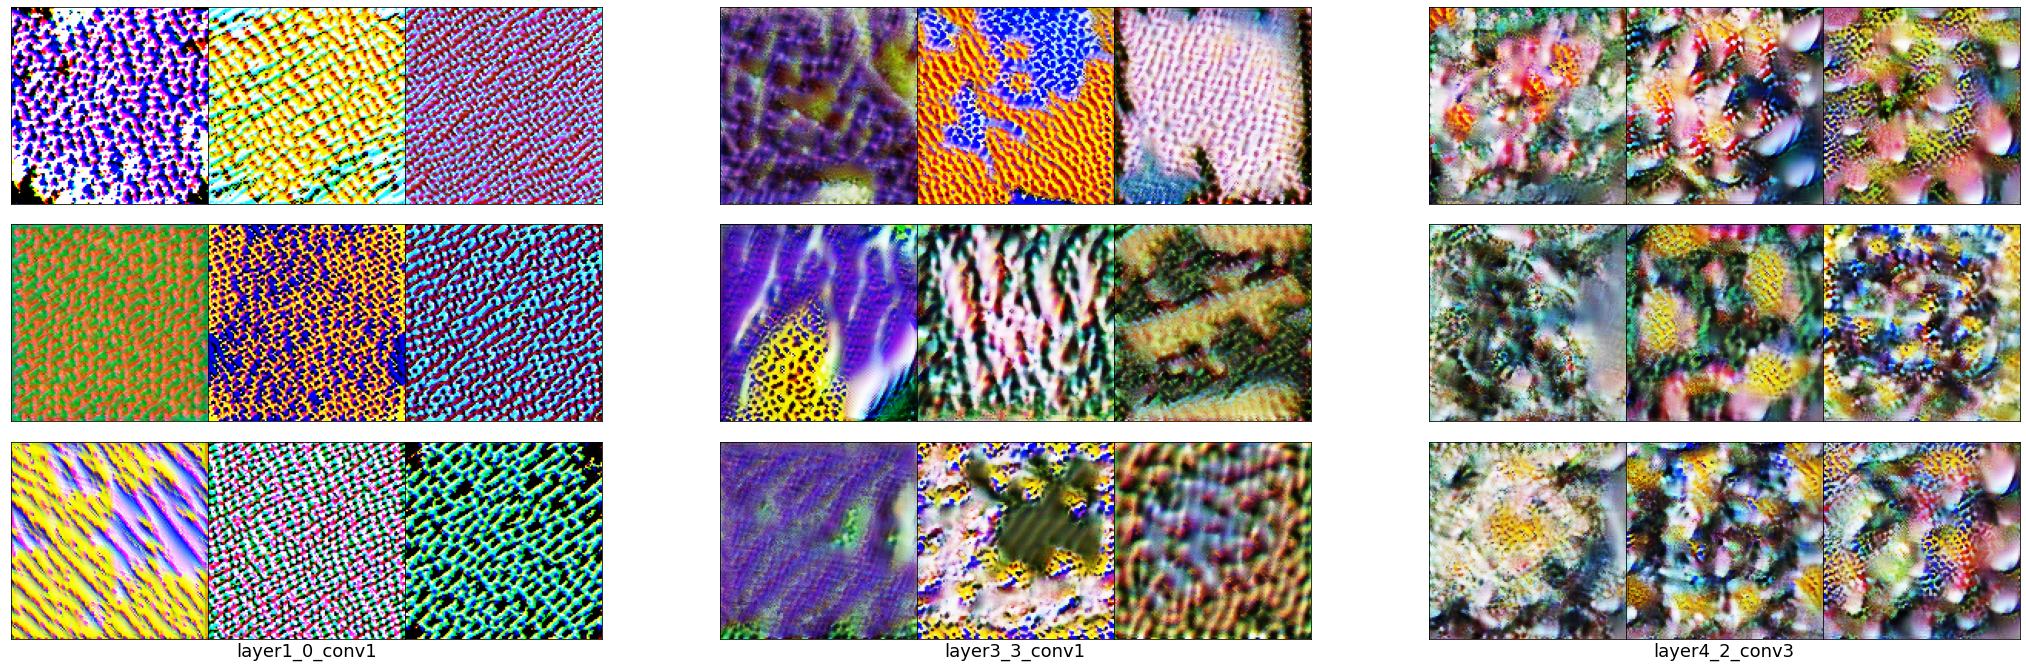

In [17]:
get_images(model, ['layer1_0_conv1', 'layer3_3_conv1', 'layer4_2_conv3'], 3, 3, preprocess=False)

###Se puede apreciar como los features evolucionan de patrones de colores a ciertas figuras mas complejas.

<br>


#**Respuesta Actividad 3:**

<br>

###Elegimos 3 clases de flores al azar del dataset:


<br>

###**Clase 11: Snapdragon**

<br>

![Snapdragon](https://www.johnnyseeds.com/dw/image/v2/BBBW_PRD/on/demandware.static/-/Sites-jss-master/default/dwffc51a88/images/products/flowers/1949_01_potomac_orange.jpg?sw=387&cx=302&cy=0&cw=1196&ch=1196)


<br>

###**Clase 42: Daffodil**

![Daffodil](https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/daffodil-shortage-mild-weather-1551084617.jpg?crop=0.989xw:0.624xh;0.00641xw,0.222xh&resize=1200:*)


<br>

###**Clase 97: Mallow**

![mallow](https://www.eatweeds.co.uk/wp-content/uploads/Mallow-FI2.png)


/usr/local/lib/python3.6/dist-packages/lucent/optvis/param/spatial.py:57: UserWarning: The function torch.irfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.ifft or torch.fft.irfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:602.)
  image = torch.irfft(scaled_spectrum_t, 2, normalized=True, signal_sizes=(h, w))
100%|██████████| 512/512 [00:14<00:00, 35.99it/s]



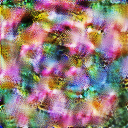

100%|██████████| 512/512 [00:13<00:00, 36.75it/s]



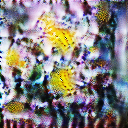

100%|██████████| 512/512 [00:13<00:00, 36.83it/s]



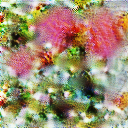

In [ ]:
_ = render.render_vis(model, 'labels:10', show_inline=True, preprocess=False)
_ = render.render_vis(model, 'labels:41', show_inline=True, preprocess=False)
_ = render.render_vis(model, 'labels:96', show_inline=True, preprocess=False)

<br>

###Se lográ ver que las imagenes tienen algunas similitudes con las originales como algunos colores. Pero en ninguna se logra apreciar grandes similitudes.

<br>



#**Respuesta Actividad 4:**


<br>


In [ ]:
import torch
import torchvision.models as models
import torch.nn as nn
 

model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(2048, 102)

In [ ]:
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torchvision.models import alexnet
from torchvision.transforms import Compose, ToTensor, Resize, Normalize
    

model = model.cuda()    # Lo enviamos para que se ejecute en GPU
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transforms = Compose([Resize((224, 224)), ToTensor(), Normalize(mean, std)])
ds_train = Flowers("flowers_dataset/train", transform=transforms) # Creamos

n_epochs = 20
train_dl = DataLoader(ds_train, batch_size=128, shuffle=True)

optimizer = Adam(model.parameters(), lr=0.001)    # Creamos nuestro optimizador
loss_function = CrossEntropyLoss()      # Creamos la función de pérdida


model.train()                           # Dejamos el modelo en modo de entrenamiento
for epoch in range(1, n_epochs + 1):
    
    total_correctas = 0.0
    total_muestras = 0.0

    for x, target in train_dl:          # Iteramos sobre nuestros datos
        # Inicio de la iteración
        optimizer.zero_grad()           # Hacemos cero los gradientes de nuestros parámetros
        x = x.cuda()
        target = target.cuda()          # Enviamos nuestros datos a GPU/ target=objetivo que queremos predecir
        output = model(x)               # Hacemos el forward de nuestros datos

        loss = loss_function(output, target)     # Calculamos la pérdida
        loss.backward()                          # Backpropagation
        optimizer.step()                         # Actualizamos parámetros

        preds = output.argmax(dim=1)             # El máximo valor es nuestra predicción
        correctas = (preds == target).sum()      # Acumulamos las correctas durante la época
        total_correctas += correctas               
        total_muestras += target.shape[0]        # Sumamos el tamaño del batch

        accuracy = total_correctas/total_muestras # Acc = correctas/total

        print("\rEpoca {}: Loss: {:.2f} Correctas: {} Total: {} Accuracy: {:.2f}%".format(epoch,
                                                                                      loss,
                                                                                      total_correctas, 
                                                                                      total_muestras,
                                                                                      100*accuracy), end="")
    print("")

Epoca 1: Loss: 1.74 Correctas: 2424.0 Total: 5687.0 Accuracy: 42.62%
Epoca 2: Loss: 0.83 Correctas: 4781.0 Total: 5687.0 Accuracy: 84.07%
Epoca 3: Loss: 0.50 Correctas: 5245.0 Total: 5687.0 Accuracy: 92.23%
Epoca 4: Loss: 0.41 Correctas: 5402.0 Total: 5687.0 Accuracy: 94.99%
Epoca 5: Loss: 0.27 Correctas: 5453.0 Total: 5687.0 Accuracy: 95.89%
Epoca 6: Loss: 0.27 Correctas: 5524.0 Total: 5687.0 Accuracy: 97.13%
Epoca 7: Loss: 0.29 Correctas: 5553.0 Total: 5687.0 Accuracy: 97.64%
Epoca 8: Loss: 0.27 Correctas: 5583.0 Total: 5687.0 Accuracy: 98.17%
Epoca 9: Loss: 0.14 Correctas: 5620.0 Total: 5687.0 Accuracy: 98.82%
Epoca 10: Loss: 0.14 Correctas: 5641.0 Total: 5687.0 Accuracy: 99.19%
Epoca 11: Loss: 0.12 Correctas: 5652.0 Total: 5687.0 Accuracy: 99.38%
Epoca 12: Loss: 0.10 Correctas: 5661.0 Total: 5687.0 Accuracy: 99.54%
Epoca 13: Loss: 0.08 Correctas: 5658.0 Total: 5687.0 Accuracy: 99.49%
Epoca 14: Loss: 0.08 Correctas: 5666.0 Total: 5687.0 Accuracy: 99.63%
Epoca 15: Loss: 0.08 Correcta

In [ ]:
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torchvision.models import alexnet
ds_test = Flowers("flowers_dataset/test", transform=transforms)
test_dl = DataLoader(ds_test, batch_size=1024)

total_correctas = 0.0
total_muestras = 0.0

for x, target in test_dl:          # Iteramos sobre nuestros datos
    # Inicio de la iteración
    model.eval()                        # Dejamos el modelo en modo evaluación
    with torch.no_grad():               # No se calculará información de gradientes
                                        # en el código de más abajo.
        x = x.cuda()
        target = target.cuda()          # Enviamos nuestros datos a GPU
        output = model(x)               # Hacemos el forward de nuestros datos

        loss = loss_function(output, target)     # Calculamos la pérdida

        preds = output.argmax(dim=1)             # El máximo valor es nuestra predicción
        correctas = (preds == target).sum()      # Acumulamos las correctas durante la época
        total_correctas += correctas               
        total_muestras += target.shape[0]        # Sumamos el tamaño del batch

        accuracy = total_correctas/total_muestras # Acc = correctas/total

        print("\rLoss: {:.2f} Correctas: {} Total: {} Accuracy: {:.2f}%".format(loss,
                                                                                total_correctas, 
                                                                                total_muestras,
                                                                                100*accuracy), end="")

Loss: 0.15 Correctas: 2614.0 Total: 2666.0 Accuracy: 98.05%


<br>

###Al ocupar la version pre-entrenada de ImageNet y entrenarlo por 20 epocas se obtiene un 99.89% de accuracy en el set de train y un 98.05% en el set de test

<br>


In [ ]:
torch.save(model.state_dict(), "pesos_modelo_entrenado.pth") # Guardamos a disco los pesos


<br>


#**Respuesta Actividad 5:**


<br>

100%|██████████| 512/512 [00:09<00:00, 51.40it/s]



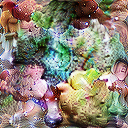

100%|██████████| 512/512 [00:09<00:00, 51.42it/s]



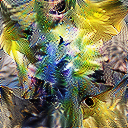

100%|██████████| 512/512 [00:10<00:00, 51.17it/s]



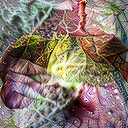

In [ ]:
_ = render.render_vis(model, 'labels:10', show_inline=True)
_ = render.render_vis(model, 'labels:41', show_inline=True)
_ = render.render_vis(model, 'labels:96', show_inline=True)

####Se pueden distinguir razgos muy característicos asociados a las plantas en las clases. La arquitectura aprendio a reconocer las plantas efectivamente por su aspecto visual. 

<br>

####La diferencia es más que evidente, en el caso del modelo en el que solo tomamos pesos pre-entrenado de la actividad 1 no se aprecian cláramente los colores y texturas asociados a las flores que elegimos.

<br>

#### Por el contrario a el modelo entrenado en la cuarta actividad, podemos apreciar que al tener mayor cantidad de datos, normalizando y entrenando nuestro modelo a partir de modelos ya preentrenados se podrían obtener mejores resultados.
